## Imports 
Para realização do projeto foram escolhidas as seguintes bibliotecas, juntamente com elas estarão listadas as principais funcionalidades das mesmas nesse contexto:  
* Pandas - Processamento de dados e leitura do arquivo .csv
* Numpy - Operações envolvendo álgebra linear
* Matplotlib - Visualização de dados
* Nltk - Processamento de linguagem natural
* Sklearn - Mineração de dados e análise de dados
* Seaborn - Visualização de dados

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import nltk
import seaborn as sns

df_train = pd.read_csv('train.csv')

Analisando o cabeçalho do _data frame_

In [2]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Verificando a quantidade de tweets marcados como discurso de ódio ou não para decisão de métrica de avaliação.

In [3]:
print(str(len(df_train[df_train.label == 1])) + ' Hatred Tweets')
print(str(len(df_train[df_train.label == 0])) + ' Non-Hatred Tweets')

2242 Hatred Tweets
29720 Non-Hatred Tweets


Baseado no OutPut obtido da quantidade de tweets que contém discurso de ódio ou não, pode-se afimar que a métrica F1 score será a melhor para esse contexto, por

## Pre-processamento dos dados
O dataset apresenta uma série de menções a usuários e para não expor nenhum, os nomes foram substituídos por _"user"_. Logo, esse tipo de infomação deve ser descartada por não apresentar nenhum valor para a análise final.  
Já as hashtags presentes nos tweets serão movidas para outra coluna para futuro tratamento.  
Para ambos os tratamentos serão utilizadas expressões regulares para localização desses padrões de palavras.

In [4]:

def remove_mentions(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = tweets.lower()
    return tweets

In [5]:
df_train['processed_text'] = df_train.tweet.apply(remove_mentions)

,id,label,tweet,processed_text
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [6]:
def extract_hashtags(df):
    hashtags = df['processed_text'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
    df.loc[:, 'hashtags'] = hashtags['hashtag']
    df['hashtags'].fillna('', inplace=True)
    return df

In [7]:
df_train = extract_hashtags(df_train)

,id,label,tweet,processed_text,hashtags
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday your majesty,
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...,model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,motivation


Após o tratamento do data frame, retirando as menções e agrupando as hashtags em outra coluna, é necessário ainda filtrar caracteres que não se encaixam no padrão UTF-8. Além disso, caracteres especiais também são desnecessários para análise final, o que fazem deles descartáveis para o texto que servirá como base. Para finalizar, foi realizado o processo de lematização das palavras, que é deflexionar uma palavra para seu estado "base".
Foi usada a biblioteca **nltk** e **sklearn** para auxílio no processo de tratamento de palavras e caractéres.

In [8]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import re #expressões regulares em processamentos textuais
lemma = WordNetLemmatizer()

def process_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    text = [lemma.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [10]:
df_train['processed_text'] = df_train.processed_text.apply(process_text)


,id,label,tweet,processed_text,hashtags
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday majesty,
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,model
4,5,0,factsguide: society now #motivation,factsguide society motivation,motivation


**Data frame inicial após tratamento:**

In [14]:
df_train.head()

,id,label,tweet,processed_text,hashtags
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...,run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,3,0,bihday your majesty,bihday majesty,
3,4,0,#model i love u take with u all the time in ...,model love u take u time ur,model
4,5,0,factsguide: society now #motivation,factsguide society motivation,motivation


### Visualização de palavras mais frequentes
Para melhor visualização das palavras que mais se repetem no dataset analisado, será implementado uma nuvem de palavras, utilizando a biblioteca wordcloud.

In [15]:
from wordcloud import WordCloud, STOPWORDS

In [16]:
all_words = ' '.join(df_train.processed_text)
hatred_words = ' '.join(df_train[df_train.label == 1].processed_text)

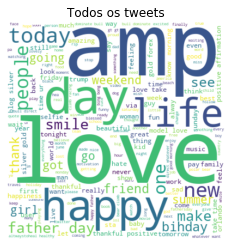

In [25]:
all_tweets_cloud = WordCloud(width=400, height=400, background_color='white', stopwords=STOPWORDS)
all_tweets_cloud = all_tweets_cloud.generate(all_words)
plt.imshow(all_tweets_cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Todos os tweets')
plt.show()

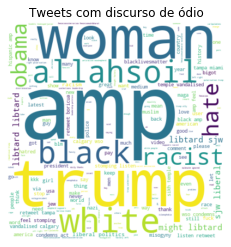

In [27]:
hatred_tweets_cloud = WordCloud(width=400, height=400, background_color='white', stopwords=STOPWORDS)
hatred_tweets_cloud = hatred_tweets_cloud.generate(hatred_words)
plt.imshow(hatred_tweets_cloud, interpolation="bilinear")
plt.axis('off')
plt.title('Tweets com discurso de ódio')
plt.show()

### Visualização de hashtags mais frequentes
Para melhor visualização das hashtags que mais se repetem no dataset analisado, serão implementados gráficos, utilizando a biblioteca seaborn, biblioteca que usa como base a matplotlib.

In [31]:
from nltk import FreqDist 

all_hashtag_frequency = FreqDist(list((" ".join(df_train.hashtags)).split())).most_common(10)

hatred_hashtag_frequency = FreqDist(list((" ".join(df_train[df_train['label']==1]['hashtags'])).split())).most_common(10)


In [38]:
df_hatredhashtags = pd.DataFrame(hatred_hashtag_frequency, columns=['words', 'frequency'])
df_allhashtags = pd.DataFrame(all_hashtag_frequency, columns=['words', 'frequency'])

,words,frequency
0,love,1600
1,positive,880
2,smile,580
3,healthy,577
4,thankful,496


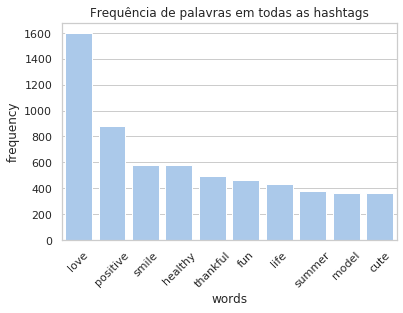

In [60]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x='words', y='frequency', data=df_allhashtags, color='b')
plt.xticks(rotation = 45)
plt.title('Frequência de palavras em todas as hashtags')
plt.show()

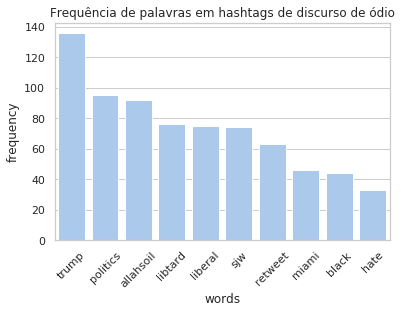

In [62]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x='words', y='frequency', data=df_hatredhashtags, color='b')
plt.xticks(rotation = 45)
plt.title('Frequência de palavras em hashtags de discurso de ódio')
plt.show()